# 1. Hard SVM with 2 features and 50 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_iris()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 

# Filter out the rows where y is 2
mask = (y != 2)
X_filtered = X[mask]  # Only keep rows where y is not 2
y_filtered = y[mask]  # Only keep corresponding labels

# Encode y to be +1 and -1
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_encoded[y_encoded == 0] = -1  # Replace 0 with -1

# Now X_filtered contains the features and y_encoded contains the -1 and +1 labels
data_X = X_filtered[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
data_y = y_encoded

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

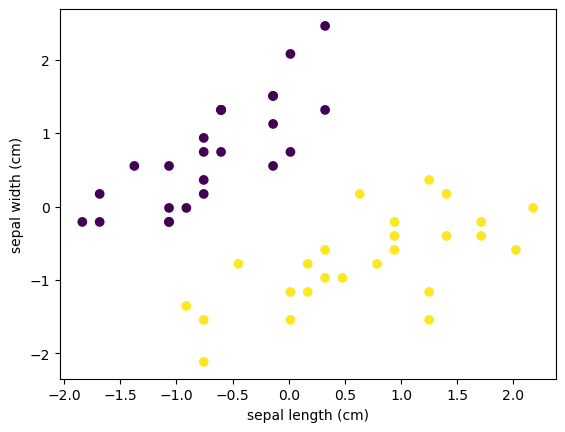

In [4]:
n = 50
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')

In [5]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(10, 8))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Class 1')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Class -1')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'Feature {feature_x_idx + 1}')
    plt.ylabel(f'Feature {feature_y_idx + 1}')
    plt.legend()
    plt.title('Hard Margin SVM Decision Boundary')
    plt.show()

In [6]:
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(10, 8))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Class 1')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Class -1')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    plt.legend([h1[0], h2[0]], ['Ground Truth', 'ODE Solution'], loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'Feature {feature_x_idx + 1}')
    plt.ylabel(f'Feature {feature_y_idx + 1}')
    plt.title('SVM Decision Boundaries (Ground Truth vs ODE Solution)')
    plt.show()

time: 0.014064550399780273
3.1509014924656853
Optimal w:  [ 1.66113497 -1.88213538]
Optimal b:  [0.27179426]


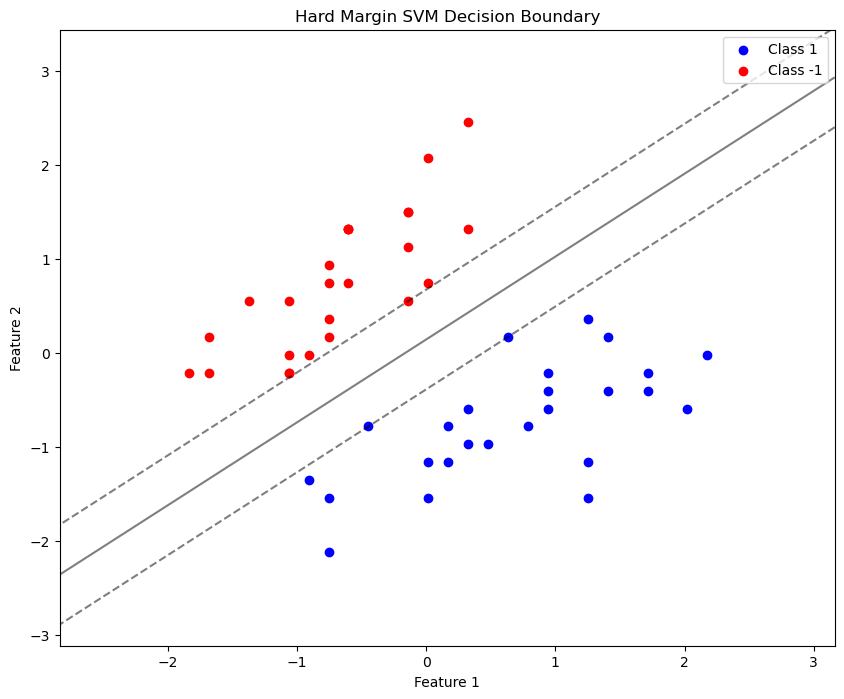

In [7]:
import cvxpy as cp
import numpy as np
import time

w = cp.Variable(2)
b = cp.Variable(1)

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2)

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1,
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
print('time: ' + str(time.time()-t0))
print(problem.value)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)
# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

In [8]:
nw = selected_X.shape[1]
nb = 1
nx = nw + nb
nu = selected_X.shape[0]
NY = nx+nu

def f(x):
    w = x[:-1]
    output = (1/2) * jnp.linalg.norm(w, 2)**2
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    
    g = [-selected_y[i] * (w @ selected_X[i] + b) + 1 for i in range(selected_y.shape[0])]
    output = jnp.array(g)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.5).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

In [9]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nw + nb].set(1.0)

sol = solve_ivp(ODE, [0., 100.], xu0, t_eval=np.arange(0, 100, 0.01), method='BDF')
result = P(sol.y[:, -1])
print(evalutation(result))
print(result)


3.112033
[ 1.64706459 -1.87383151  0.2721647   0.          0.          0.
  0.          0.          0.          0.00007436  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.00007436  0.          0.
  0.71254885  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          3.127305    0.          0.
  0.          0.          0.          0.          0.          2.41471889
  0.          0.          0.         -0.          0.        ]


In [10]:
g(result[:nx])

Array([-2.8447313 , -1.5185131 , -1.0652546 , -1.3601426 , -2.1924527 ,
       -1.367427  , -0.08895056, -2.1853604 , -1.7800359 , -1.9934326 ,
       -0.9139763 , -3.5115786 , -0.19210279, -2.3362546 , -3.7105987 ,
       -2.8926651 , -0.65264565, -0.29525504, -0.08895056, -1.4776714 ,
       -2.0340822 , -0.00017495, -1.2161486 , -2.5979693 , -2.1853604 ,
       -1.9309299 , -1.7248175 , -1.1131885 , -1.7800359 , -1.882996  ,
       -2.02699   , -4.22636   , -0.4463412 , -0.65245354, -1.6287576 ,
       -2.4873407 ,  0.0069173 , -1.1059041 , -0.9212607 , -0.65993005,
       -0.30963165, -1.7319099 , -1.2640826 , -1.8206854 ,  0.00710943,
       -1.0171286 , -2.1853604 , -1.5735393 , -2.8042738 , -0.09623493],      dtype=float32)

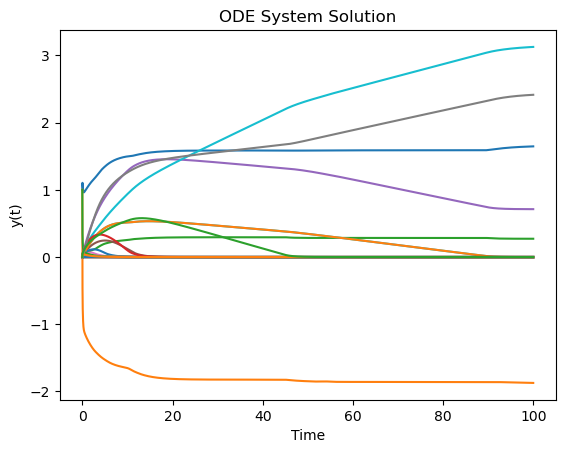

In [11]:
t_values = sol.t
y_values = sol.y

plt.plot(t_values, y_values.T)
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('ODE System Solution')
plt.show()

In [12]:
T=100.0

In [13]:
w_op = w.value
b_op = b.value

w_ode = result[:data_X.shape[1]]
b_ode = result[:data_X.shape[1]]

w_1_abs_diff = np.abs(w_op[0] - w_ode[0])
w_2_abs_diff = np.abs(w_op[1] - w_ode[1])
b_abs_diff = np.abs(b_op[0] - b_ode)

# Calculate the squared differences
w_1_sq_diff = w_1_abs_diff ** 2
w_2_sq_diff = w_2_abs_diff ** 2
b_sq_diff = b_abs_diff ** 2

mse_ = (w_1_sq_diff + w_2_sq_diff + b_sq_diff) / 3

print('w_1 absolute difference:', w_1_abs_diff)
print('w_2 absolute difference:', w_2_abs_diff)
print('b absolute difference:', b_abs_diff)

print('\nMSE between the two solutions:', mse_)

w_1 absolute difference: 0.014070379435386027
w_2 absolute difference: 0.008303866732648935
b absolute difference: 0.00037043844896589295

MSE between the two solutions: 8.902233493793331e-05


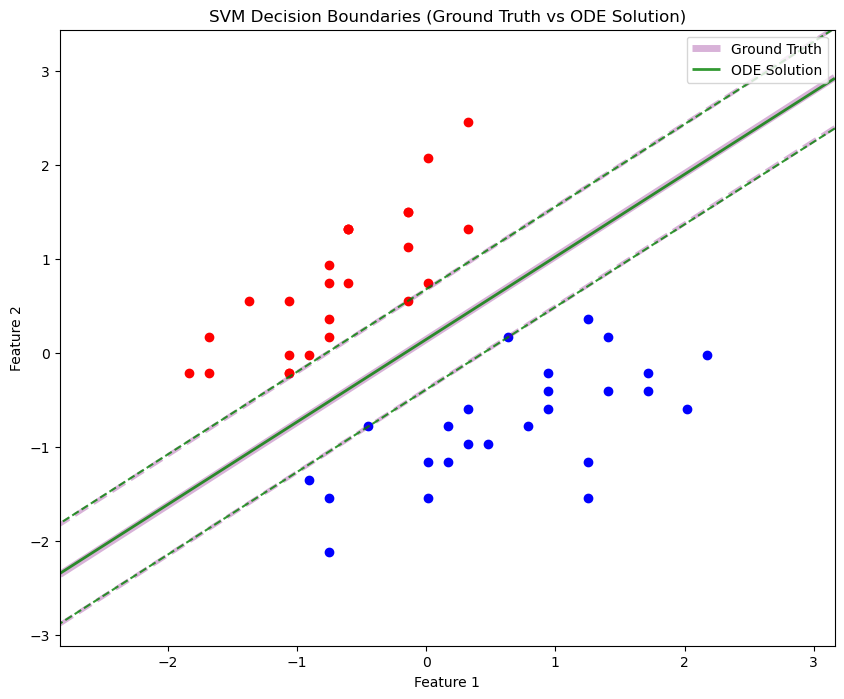

In [14]:
plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_op, b_op, w_ode, b_ode, 0, 1)

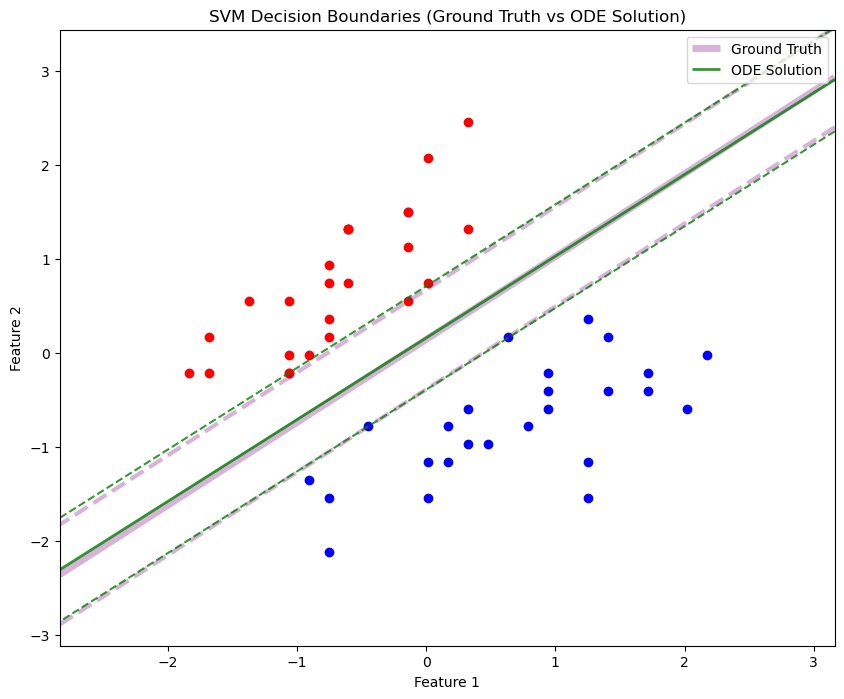

Array([-2.7220109 , -1.3924803 , -0.9687804 , -1.2266287 , -2.118206  ,
       -1.2512469 , -0.00865411, -2.0455217 , -1.6606934 , -1.938101  ,
       -0.87561315, -3.3750522 , -0.11101573, -2.234821  , -3.5551572 ,
       -2.7608824 , -0.55933386, -0.21337736, -0.00865411, -1.4262929 ,
       -1.9523544 , -0.00359514, -1.1580797 , -2.4549682 , -2.0455217 ,
       -1.8499928 , -1.5972035 , -1.007652  , -1.6606934 , -1.8111211 ,
       -1.87967   , -4.066965  , -0.35461065, -0.60739994, -1.5675262 ,
       -2.3760543 ,  0.06908922, -0.9830338 , -0.9002315 , -0.5839522 ,
       -0.31068   , -1.6698879 , -1.1969514 , -1.6749468 ,  0.02102315,
       -0.9779748 , -2.0455217 , -1.5040363 , -2.6596913 , -0.0332724 ],      dtype=float32)

In [15]:
sol = solve_ivp(ODE, [0., 20.], xu0, t_eval=np.arange(0, 20, 0.01), method='BDF')
result = P(sol.y[:, -1])
w_ode_20 = result[:data_X.shape[1]]
b_ode_20 = result[data_X.shape[1]]
plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_op, b_op, w_ode_20, b_ode_20, 0, 1)
g(result[:nx])

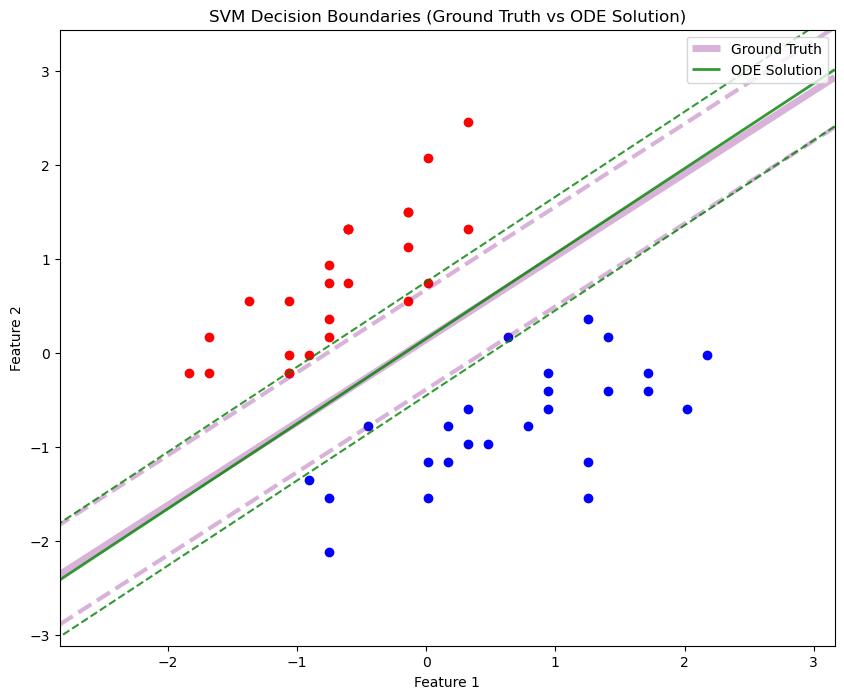

Array([-2.4802892 , -1.2553749 , -0.8145079 , -1.149936  , -1.8296423 ,
       -1.1084193 ,  0.00550022, -1.8229884 , -1.4449455 , -1.6198626 ,
       -0.71572286, -3.0479026 , -0.07863133, -2.0181148 , -3.2576823 ,
       -2.5431132 , -0.4779817 , -0.16276288,  0.00550022, -1.1992048 ,
       -1.7242033 ,  0.12449451, -1.0096343 , -2.1595147 , -1.8229884 ,
       -1.6400717 , -1.423638  , -0.87733203, -1.4449455 , -1.5772476 ,
       -1.7175493 , -3.6783402 , -0.30971855, -0.5261523 , -1.3461604 ,
       -2.1650703 ,  0.13114847, -0.9188487 , -0.6742062 , -0.436465  ,
       -0.12790015, -1.430292  , -1.0724584 , -1.5492862 ,  0.08297782,
       -0.7998544 , -1.8229884 , -1.324853  , -2.3277776 ,  0.04701691],      dtype=float32)

In [16]:
sol = solve_ivp(ODE, [0., 10.], xu0, t_eval=np.arange(0, 10, 0.01), method='BDF')
result = P(sol.y[:, -1])
w_ode_10 = result[:data_X.shape[1]]
b_ode_10 = result[data_X.shape[1]]
plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_op, b_op, w_ode_10, b_ode_10, 0, 1)
g(result[:nx])

# 3. The method

In [50]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss

    def loss_compute(self, t, net, weighting=0.5):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        loss = mse(dy, pdy) # [NBATCH, NY]
        loss = torch.sum(loss, axis=1) # [NBATCH]
        if weighting is not None:
            loss = torch.exp(-weighting*t.detach().reshape((-1, )))*loss # proprity smaller t
        loss = torch.mean(loss, axis=0)
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [51]:
y0 = np.zeros(NY)
y0[:nw + nb] = 1.0

In [52]:
NBATCH = 512 # 512
ITERATIONS = 1000
NEURONS = 400
LAYERS = 2
LR = 0.001

In [53]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.xlim(0, ITERATIONS)
     plt.legend()
     plt.grid(True)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def print_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_op - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_op[0] - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     # Print the absolute differences for all weights and bias
     print('w absolute differences:', w_abs_diff)
     print('b absolute difference:', b_abs_diff)

     # Print the MSE
     print('\nMSE between the two solutions:', mse_)

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     return mse_

LAYERS: 1 NEURONS: 400 LR: 0.001 epsilon: 4.6391864 MSE solution: 0.4770288229158428
LAYERS: 2 NEURONS: 400 LR: 0.001 epsilon: 5.080705 MSE solution: 0.35820171441368864
LAYERS: 3 NEURONS: 400 LR: 0.001 epsilon: 5.5912156 MSE solution: 0.254050986906796
LAYERS: 4 NEURONS: 400 LR: 0.001 epsilon: 8.252738 MSE solution: 0.34244579790905233
LAYERS: 5 NEURONS: 400 LR: 0.001 epsilon: 6.8854704 MSE solution: 0.3586111430193835


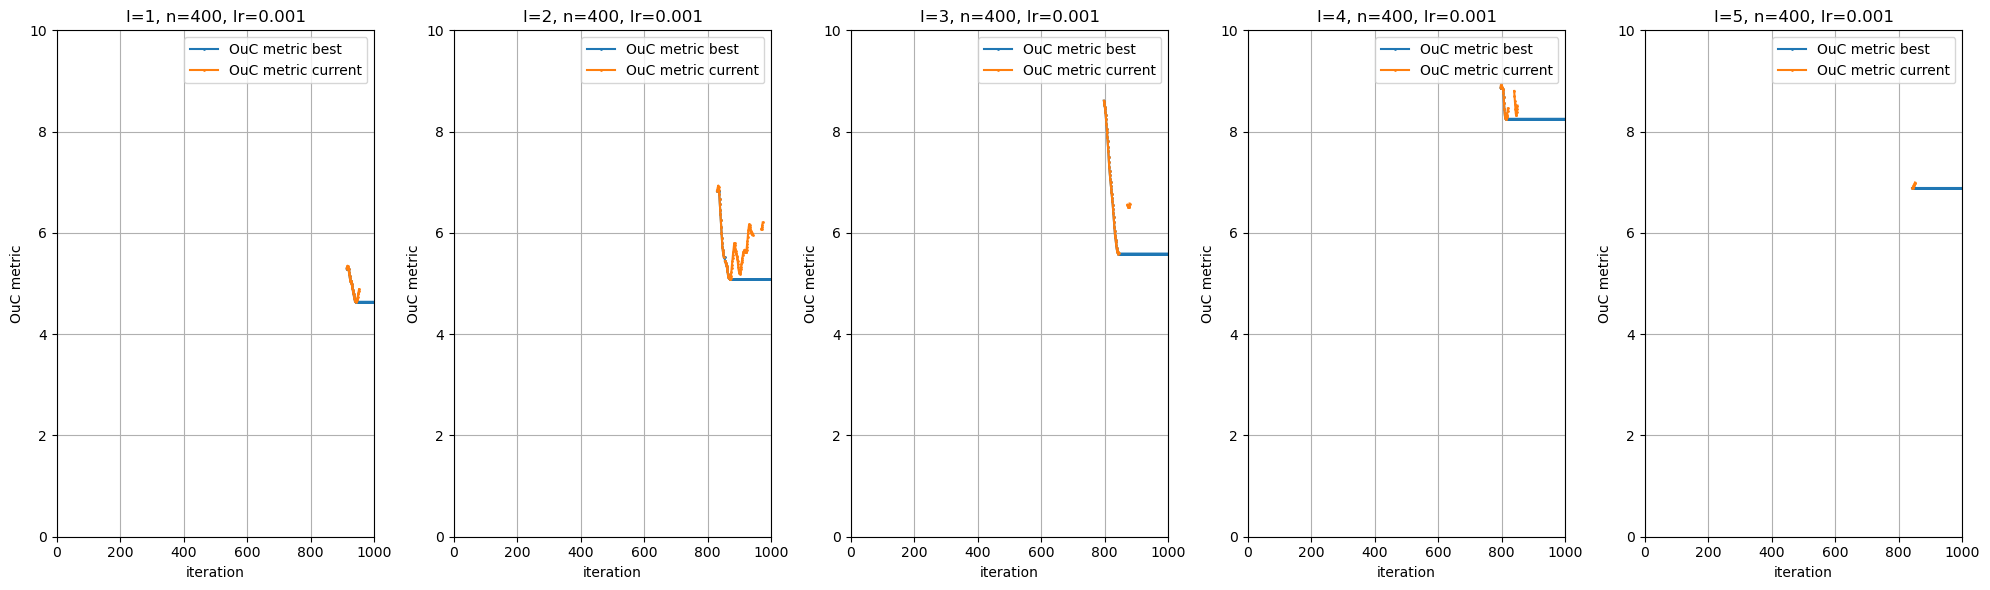

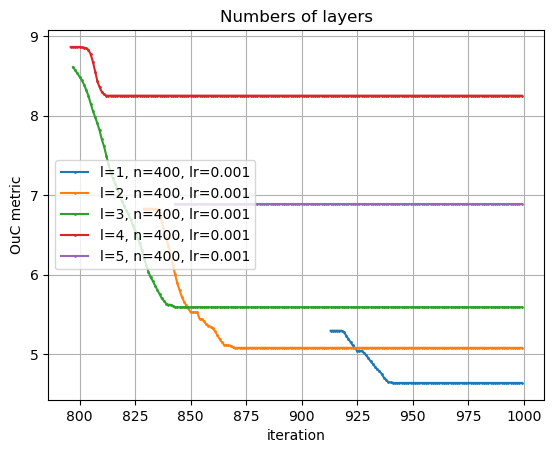

In [54]:
res_layers = try_layers([1, 2, 3, 4, 5], 400, 0.001)
plot_results(res_layers, y_max=10)
plot_result_confrontation(res_layers)

LAYERS: 2 NEURONS: 100 LR: 0.001 epsilon: 6.451514 MSE solution: 0.13797479361804374
LAYERS: 2 NEURONS: 200 LR: 0.001 epsilon: 5.4033084 MSE solution: 0.3850377760966511
LAYERS: 2 NEURONS: 300 LR: 0.001 epsilon: 5.354011 MSE solution: 0.2854941899374974
LAYERS: 2 NEURONS: 400 LR: 0.001 epsilon: 5.392311 MSE solution: 0.30206808117939654
LAYERS: 2 NEURONS: 500 LR: 0.001 epsilon: 8.545387 MSE solution: 0.25082090116668493


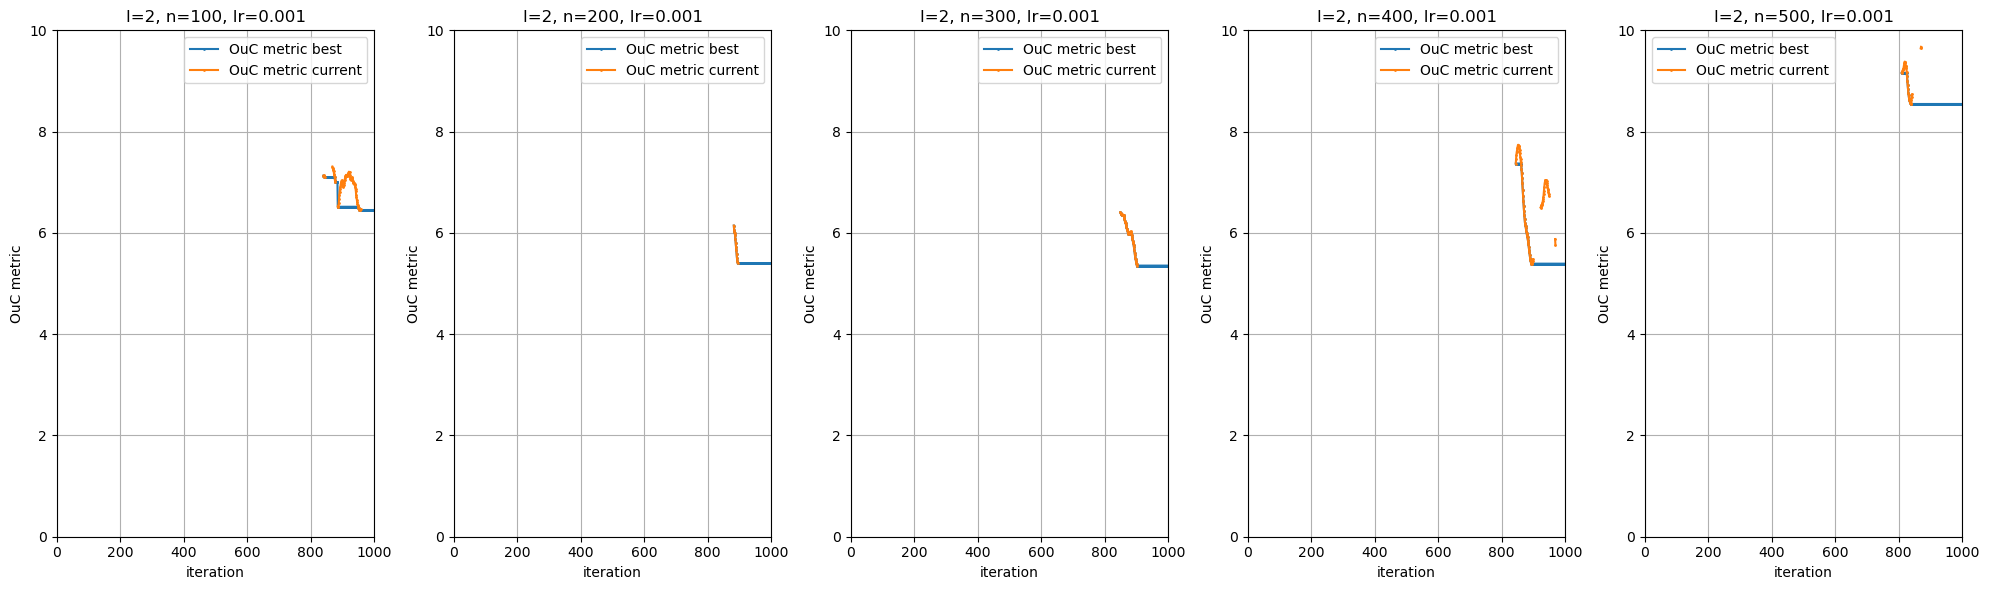

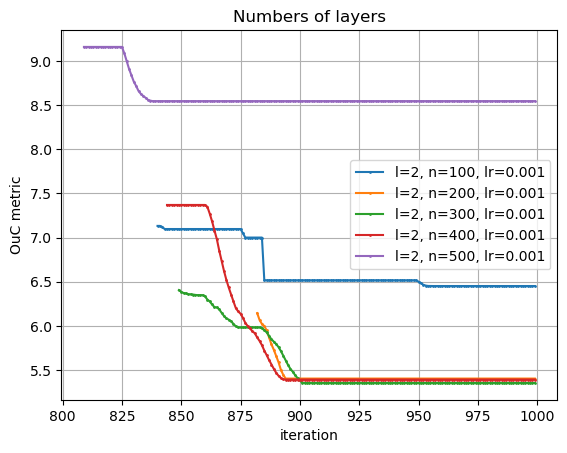

In [55]:
res_neurons = try_neurons([100, 200, 300, 400, 500], 2, 0.001)
plot_results(res_neurons, y_max=10)
plot_result_confrontation(res_neurons)

LAYERS: 5 NEURONS: 500 LR: 0.0001 epsilon: 7.1292195 MSE solution: 0.21966243559114962
LAYERS: 5 NEURONS: 500 LR: 0.001 epsilon: 4.5075183 MSE solution: 0.44756185731482384
LAYERS: 5 NEURONS: 500 LR: 0.01 epsilon: 5.771031 MSE solution: 0.34616136302495487
LAYERS: 5 NEURONS: 500 LR: 0.1 epsilon: 4.955112 MSE solution: 0.495024682268228


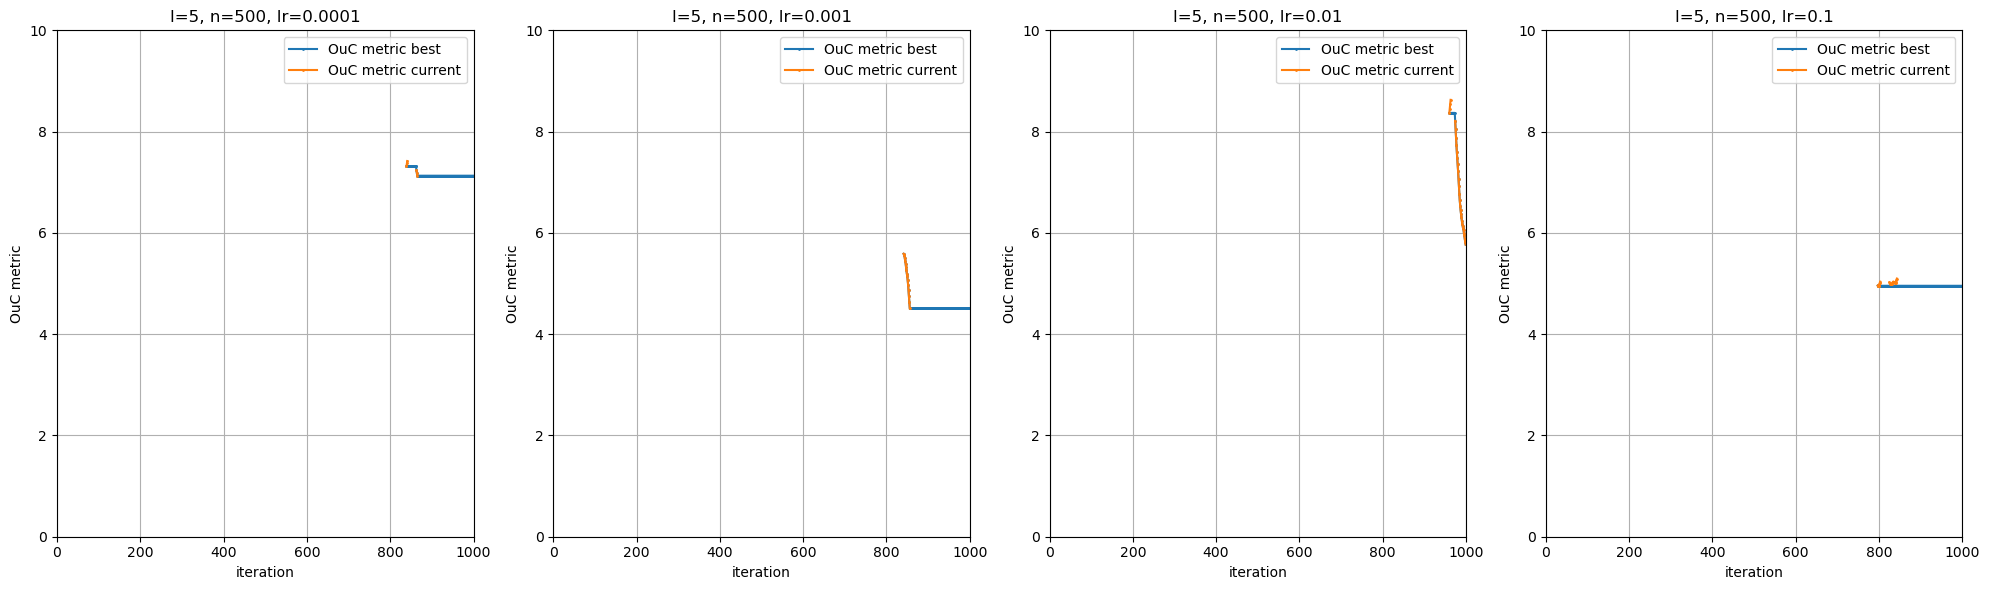

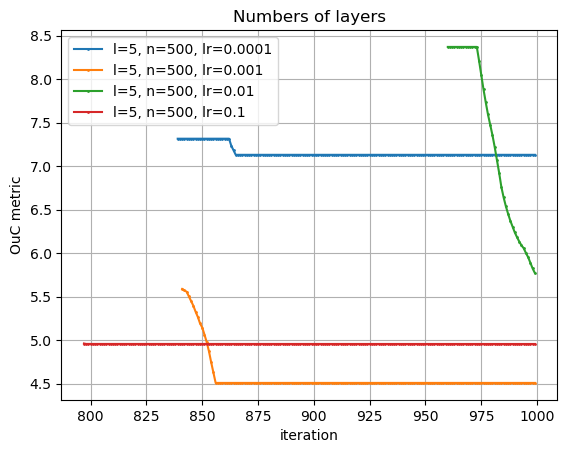

In [56]:
res_learning_rate = try_lr([0.0001, 0.001, 0.01, 0.1], 5, 500)
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)